# Trabajo Final Sistemas de Bases de datos Masivos

Con el presente trabajo pretendemos dar a conocer los resultados de    las encuestas realizadas por la comunidad de desarrolladores *Stackoverflow*, desde el año 2011 al 2017, además de una proyección de los resultados una posible encuesta en 2018.    Presentaremos desde la obtención y limpieza de los datos, pasando por    el analisis de tendencias, hasta la actualización de indicadores    mediante rutinas en diferentes herramientas que nos permiten poner en    practica los conocimientos adquiridos en la presente asignatura.

## 1. Obtención y Limpieza de los datos

### Obtención

Los datos se obtuvieron mediante la herramienta **BigQuery** donde se encuentran disponibles las preguntas de las encuestas como datos abiertos. En total son 7 conjuntos de datos que se guardaron en un conjunto de datos propios con el total de registros y columnas de cada año mediante la siguiente consulta:

In [ ]:
CREATE TABLE `Clase2_seccion2.survey_2011` 
AS
SELECT * FROM `fh-bigquery.stackoverflow.survey_results_2011`


De cada conjunto de datos se extrajo un limite de 100 registros para mapear las preguntas mediante archivos csv.

Para saber que tipo de preguntas habian en las encuestas se hizo la siguiente rutina de **Python** que permitia buscar campos repetidos en los 7 conjuntos de datos

In [ ]:
archivos = ['2011.csv', '2013.csv', '2015.csv', '2012.csv', '2014.csv','2016.csv','2017.csv']
for m in archivos: 
    print('-----') 
    print(m) 
    aa = pd.read_csv(m, sep=',', encoding='latin')
    print(aa.columns.values) 
    print('\n')

De esta forma se determinaron las preguntas que van a hacer parte de la bodega de datos

| Pregunta      |2011  || 2012 || 2013 || 2014 || 2015 || 2016 || 2017 |
| ------------- |------||------||------||------||------||------||------|
| Salario       |   Y  ||   Y  ||   Y  ||   Y  ||   Y  ||   Y  ||   Y  |
| Region        |   Y  ||   Y  ||   Y  ||   Y  ||   Y  ||   Y  ||   Y  |
| Lenguajes     |   Y  ||   Y  ||   Y  ||   Y  ||   Y  ||   Y  ||   Y  |
| Satisfacción  |   Y  ||   Y  ||   Y  ||   N  ||   Y  ||   Y  ||   Y  |
| Género        |   N  ||   N  ||   N  ||   Y  ||   Y  ||   Y  ||   Y  |
| Os            |   Y  ||   Y  ||   Y  ||   Y  ||   Y  ||   Y  ||   Y  |
| Edad          |   Y  ||   Y  ||   Y  ||   Y  ||   Y  ||   Y  ||   N  |
| Experiencia   |   Y  ||   Y  ||   Y  ||   Y  ||   Y  ||   Y  ||   Y  |
| Company Size  |   Y  ||   Y  ||   Y  ||   Y  ||   N  ||   Y  ||   Y  |

Con las preguntas ya mapeadas, en **BigQuery** se hizo el respectivo filtro de las columnas necesarias con la cantidad total de filas y se exportó la información en formatos *JSON* y *CSV*

    SELECT 
    YearsProgram,Country,Salary,HaveWorkedLanguage,JobSatisfaction,Gender,HaveWorkedPlatform,companySize
    FROM `clase1-seccion2.Clase2_seccion2.survey_2017`

### Limpieza

Para la limpieza se generaron reglas que permitieran estandarizar todos los años como definir el rango de edad, salario, tamaño de la compañia, experiencia. El campo satisfacción de las encuestas es un campo subjetivo, por lo que se decidió darle un número 1 a 5 siendo 5 la mejor satisfacción y 1 la peor. El campo Lenguajes es una lista concatenada por comas de todas las respuestas que aparecian en las encuestas como columnas:



Age Range: [0, 20] [21, 25] [26, 30] [31, 40] [41, 50] [>50]
Experience Range: [0, 2] [3, 5] [6, 10] [10, 15] [15, 20] [20, 90]
Salary Range: [<20k] [20k, 40k] [40k, 60k] [60k, 80k] [80k, 100k] [100k, 120k] [120k, 140k] [>140k]
company size: [1, 25] [26, 100] [101, 1000] [>1000]
Satisfaction: Subjetive
    2011 --> {enjoy: 5, hurts: 4, not happy: 1, bills: 3}
    2012 --> {love: 5, enjoy: 4, hate: 1, not happy: 2, paycheck: 3, wish a job: None}
    2013 --> {love: 5, enjoy: 4, hate: 1, not happy: 2, paycheck: 3, wish a job: None}
    2015 --> {love: 5, I'm somewhat satisfied with my job: 4, hate: 1, I'm somewhat dissatisfied with my job: 2, I'm neither satisfied nor dissatisfied with my job: 3, Other: None}
    2016 --> {love: 5, I'm somewhat satisfied with my job: 4, hate: 1, I'm somewhat dissatisfied with my job: 2, I'm neither satisfied nor dissatisfied with my job: 3, Other: None, I don't have a job: None}
    2011 --> [nan, 7., 8., 5., 9., 6., 2., 10., 0., 4., 3., 1.]

Para la limpieza se generó una clase en **Python**, la rutina de limpieza la puedes encontrar en este [link](https://github.com/jgarciade/bigdata/blob/master/queries/Data%20Clean%20Routines.ipynb)

In [ ]:
import json
import re
_STRING_BASE_NAME = 'string_field_'

'''
2011 data type

[
  {
    "string_field_0": "United States of America",
    "string_field_2": "40-50",
    "string_field_3": "11",
    "string_field_45": ">$140,000",
    "string_field_30": null,
    "string_field_31": null,
    "string_field_32": null,
    "string_field_33": null,
    "string_field_34": "Python",
    "string_field_35": null,
    "string_field_36": null,
    "string_field_37": null,
    "string_field_38": null,
    "string_field_39": "C",
    "string_field_40": null,
    "string_field_41": null,
    "string_field_42": null,
    "string_field_44": "I enjoy going to work",
    "string_field_43": "Linux",
    "string_field_5": "Fortune 1000 (1,000+)"
  }
]

'''


class Cleaner():
    '''
    cleans data from JSON files to fit business logic
    '''
    _salary_ranges = {
        1: [0, 20],
        2: [20, 40],
        3: [40, 60],
        4: [60, 80],
        5: [80, 100],
        6: [100, 120],
        7: [120, 140]
    }

    _company_size_range = {
        1: [1, 25],
        2: [26, 100],
        3: [101, 1000]
    }

    _age_range = {
        1: [0, 20],
        2: [21, 25],
        3: [26, 30],
        4: [31, 40],
        5: [41, 50]
    }

    _experience_range = {
        1: [0, 2],
        2: [3, 5],
        3: [6, 10],
        4: [10, 15],
        5: [15, 20],
        6: [20, 90]
    }

    def __init__(self, data_fields, satisfaction_map, path_to_file):
        '''
        @data_fields: { age': 2, 'experience': 3, 'region': 0, 'salary': 100,
                        'programming_languages': [56, 69], 'satisfaction': 99,
                        'gender': None, 'os': 81, 'company_size': 5
                      }
        @satisfaction_map: {enjoy: 5, hurts: 4, not happy: 1, bills: 3}
        @path_to_file: /path
        '''
        self._data_fields = data_fields
        self._satisfaction_map = satisfaction_map
        self._path_to_file = path_to_file
        self._raw_data = None

    def _read_file(self):
        with open(self._path_to_file) as f:
            self._raw_data = json.load(f)

    def _create_list_from_field(self, data, field):
        result = []
        pl_indexes = self._data_fields.get(field)
        if len(pl_indexes) == 1:
            value = data.get(f'{_STRING_BASE_NAME}{pl_indexes[0]}')
            is_valid = self._is_valid_value(value)
            if not is_valid:
                value = None
            result.append(value)
            return result

        for i in range(pl_indexes[0], pl_indexes[1] + 1):
            value = data.get(f'{_STRING_BASE_NAME}{i}')
            is_valid = self._is_valid_value(value)

            if value is not None and is_valid:
                result.append(value)

        return result

    def _extract_programming_languages(self, data):
        return self._create_list_from_field(data, 'programming_languages')

    def _extract_os(self, data):
        return self._create_list_from_field(data, 'os')

    def _extract_upper_limit_num_from_string(self, value):
        # Extracts the max raw salary value
        value = value.replace(',', '')
        number = re.findall(r'\d+', value)
        if len(number) == 0:
            return None
        number = number[-1:][0]
        number = float(number)

        return number

    def _get_satisfaction(self, data):
        field = self._data_fields.get('satisfaction')
        satisfaction_answer = data.get(f'{_STRING_BASE_NAME}{field}')
        is_valid = self._is_valid_value(satisfaction_answer)
        if satisfaction_answer is None or not is_valid:
            return None

        for (key, value) in self._satisfaction_map.items():
            if key in satisfaction_answer:
                return value

        return None

    def _extract_range_operator(self, value):
        if value is None:
            return value
        salary_operator = value[:1]
        if salary_operator != '>' and salary_operator != '<':
            salary_operator = None
        return salary_operator

    def _extract_raw_number_from_range(self, value):
        range_operator = self._extract_range_operator(value)

        raw_number = self._extract_upper_limit_num_from_string(value)
        if raw_number is None:
            return None

        if range_operator == '>':
            raw_number += 1
        elif range_operator == '<':
            raw_number -= 1

        return raw_number

    def _get_salary_range(self, data):
        field = self._data_fields.get('salary')
        value = data.get(f'{_STRING_BASE_NAME}{field}')
        is_valid = self._is_valid_value(value)
        if value is None or not is_valid:
            return None

        salary = self._extract_raw_number_from_range(value)
        if salary is None:
            return None

        salary_range = '>140k'
        salary /= 1000

        for ran in self._salary_ranges.values():
            if salary in range(ran[0], ran[1] + 1):
                salary_range = f'{ran[0]}-{ran[1]}'
        return salary_range

    def _get_company_size_range(self, data):
        field = self._data_fields.get('company_size')
        value = data.get(f'{_STRING_BASE_NAME}{field}')

        is_valid = self._is_valid_value(value)
        if value is None or not is_valid or '/' in value:
            return None

        value = self._extract_raw_number_from_range(value)

        if value is None:
            return None

        company_size_range = '>1000'
        for ran in self._company_size_range.values():
            if value in range(ran[0], ran[1] + 1):
                company_size_range = f'{ran[0]}-{ran[1]}'
        return company_size_range

    def _get_age_range(self, data):
        field = self._data_fields.get('age')
        value = data.get(f'{_STRING_BASE_NAME}{field}')
        is_valid = self._is_valid_value(value)
        if value is None or not is_valid:
            return None

        age_range = '>50'
        age = self._extract_raw_number_from_range(value)
        if age is None:
            return None

        for ran in self._age_range.values():
            if age in range(ran[0], ran[1] + 1):
                age_range = f'{ran[0]}-{ran[1]}'
        return age_range

    def _get_experience_range(self, data):
        field = self._data_fields.get('experience')
        value = data.get(f'{_STRING_BASE_NAME}{field}')
        is_valid = self._is_valid_value(value)
        if value is None or not is_valid:
            return None

        experience_range = None
        experience = self._extract_raw_number_from_range(value)
        if experience is None:
            return None

        for ran in self._experience_range.values():
            if experience in range(ran[0], ran[1] + 1):
                experience_range = f'{ran[0]}-{ran[1]}'
        return experience_range

    def _get_raw_value_from_data(self, data, key):
        key_index = self._data_fields.get(key, None)
        if key_index is None:
            return None

        value = data.get(f'{_STRING_BASE_NAME}{key_index}')
        is_valid = self._is_valid_value(value)
        if not is_valid:
            value = None
        return value

    def _is_valid_value(self, value):
        if value is None:
            return False
        is_valid = True
        is_valid = is_valid and ('?' not in value)
        is_valid = is_valid and ('please' not in value.lower())
        is_valid = is_valid and ('response' not in value.lower())

        return is_valid

    def _extract_values(self):
        self._read_file()
        results = []
        for data in self._raw_data:
            fields = {}
            fields.update({'programming_languages': self._extract_programming_languages(data)})
            fields.update({'os': self._extract_os(data)})
            fields.update({'salary_range': self._get_salary_range(data)})
            fields.update({'satisfaction': self._get_satisfaction(data)})
            fields.update({'company_size_range': self._get_company_size_range(data)})
            fields.update({'age_range': self._get_age_range(data)})
            fields.update({'experience_range': self._get_experience_range(data)})
            fields.update({'gender': self._get_raw_value_from_data(data, 'gender')})
            fields.update({'region': self._get_raw_value_from_data(data, 'region')})
            fields.update({'gender': self._get_raw_value_from_data(data, 'gender')})
            results.append(fields)
        return results

    def clean_and_save(self, file_path_to_save):
        results = self._extract_values()
        with open(file_path_to_save, 'w') as outfile:
            json.dump(results, outfile, indent=4, sort_keys=True)

kwargs = {'data_fields': {'age': 1, 'experience': 4, 'region': 0, 'salary': 105,
                          'programming_languages': [8, 50], 'satisfaction':109,
                          'gender': 2, 'os': [6], 'company_size': None},
            'satisfaction_map': {'Love': 5, 'somewhat satisfied': 4, 'Hate': 1, 'somewhat dissatisfied': 2,'neither': 3, 'Other': None},
            'path_to_file': 'raw_data/2015.json'
            }
cleaner = Cleaner(**kwargs)
cleaner.clean_and_save('clean_files/2015.json')

Mediante las anteriores rutinas se generan nuevos archivos *JSON* que harán parte de la bodega de datos

# 2. Bodega de Datos

Con los 7 conjuntos de datos y el conjunto adicional que contiene todos los años anteriores, se crea la bodega de datos en **MongoDB**

<img src='https://github.com/jgarciade/bigdata/blob/master/images/bodega.PNG'/>

Se genera la bodega de datos mediante las siguientes lineas de código

Mediante la bodega de datos podemos responder las siguientes preguntas:

1. Cuál es la edad de los programadores senior en Alemania?

2. Cuáles son los 5 paises que mas tienen programadores?

3. Cuál es el Top de los 5 lenguajes más populares por año?

4. Cuál es el sistema operativo que usan los programadores de C#?

5. Cuál es el rango de edad de los programadores junior?

6. Cuantas mujeres programan en Python, Javascript y Sql?

7. En qué lenguajes se sienten más insatisfechos los programadores?

8. Cuál es el rango de salario de los programadores de Java?

9. Cuántos hombres programan en Python,Javascript y Sql?

10. Cuántas personas trabajaban en Start up en 2017?

11. número de programadores por tamaño de la compañia en 2011

12. Cuál es el lenguaje que utilizan las grandes compañias?

13. Numero de programadores por lenguaje en 2017

14. En que pais se paga mejor por programar en python?

15. Cual es el promedio de lenguajes que los programadores han utilizado?

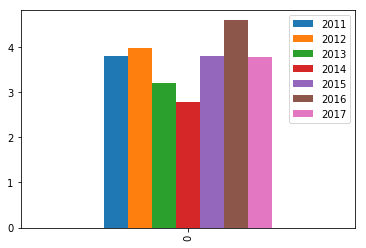

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

df=pd.DataFrame({'2011':[],'2012':[],'2013':[],'2014':[],'2015':[],'2016':[],'2017':[]})
for i in range(2011, 2018):
    
    df_local = pd.read_json(f'clean_files/{i}.json')

    df_local['programming_languages_lenght'] = df_local['programming_languages'].apply(lambda x: len(x) if x is not None else None)
    df[str(i)]=[df_local['programming_languages_lenght'].mean()]

df.plot(kind='bar')  

# 3. Representación de la bodega de datos

En la bodega de datos tenemos información por año de las variables mencionadas anteriormente por lo que esto nos permite crearnos preguntas que se puedan solucionar mediante la combinación de uno o más campos. En este caso la pregunta que queremos resolver es la ¿cantidad de mujeres que programan algún lenguaje por pais?

### Cubo

In [17]:
#Adjuntar imagen

### Estrella

In [18]:
#Adjuntar imagen

### Malinowski

In [19]:
#Adjuntar imagen

# 4. MapReduce

Mediante la herramienta **MongoDB** se creó la bodega de datos que nos permite responder la pregunta de la cantidad de programadores por lenguaje, mediante la metodología MapReduce a traves del siguiente script:

In [20]:
#Adjuntar script 

# 5. Rutina de predicción de encuesta 2018

Se creo la rutina que permite generar los 50k registros de una posible encuesta en 2018 mediante la rutina en **Python**:

In [21]:
#Adjuntar rutina

Esta rutina nos permite responder preguntas como : ¿cuántas mujeres programarán en Python en el 2018?

In [22]:
#Adjuntar script

# 6. Insertar registro en las encuestas

Mediante el siguiente script se puede ingresar registos a la bodega de datos:

In [23]:
#Adjuntar script

# 7. Actualizar registros de las encuestas

Mediante el siguiente script se puede actualizar los registos a la bodega de datos:

In [ ]:
#Adjuntar script